In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image 

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import shap


import math

In [3]:
df = pd.read_csv("../../Data/df_standard_random_split.csv")
df = df.drop(columns = ["Unnamed: 0","X","chunk"])
df

,abnormal,X1.hr,X2.hr,X3.hr,X4.hr,train_test
0,0,-0.821217,-1.226790,-1.462874,-2.035798,train
1,0,0.332288,-0.821217,-1.226790,-1.462874,train
2,0,-0.079992,0.332288,-0.821217,-1.226790,test
3,0,-0.488737,-0.079992,0.332288,-0.821217,train
4,0,0.175170,-0.488737,-0.079992,0.332288,train
...,...,...,...,...,...,...
31676,0,-0.660765,-0.700289,0.293685,0.813489,test
31677,0,0.535947,-0.660765,-0.700289,0.293685,train
31678,0,0.693141,0.535947,-0.660765,-0.700289,train
31679,0,1.855202,0.693141,0.535947,-0.660765,train


In [3]:
train = df.loc[df['train_test'] == "train"]
test = df.loc[df['train_test'] == "test"]

In [4]:
y_train = train.pop("abnormal")
X_train = train
X_train = X_train.drop(columns = ["train_test"])
y_test = test.pop("abnormal")
X_test = test
X_test = X_test.drop(columns = ["train_test"])

In [5]:
def get_results(truth, prediction, df, idx):
    

    acc = accuracy_score(truth, prediction)
    f1 = f1_score(truth, prediction)
    precision = precision_score(truth, prediction)
    recall = recall_score(truth, prediction)

    df.loc[idx,:] = [acc, f1, precision, recall]

    return df


In [6]:
results = pd.DataFrame(index = ['Decision Tree'], 
                       columns = ['accuracy', 'f1', 'precision', 'recall'])

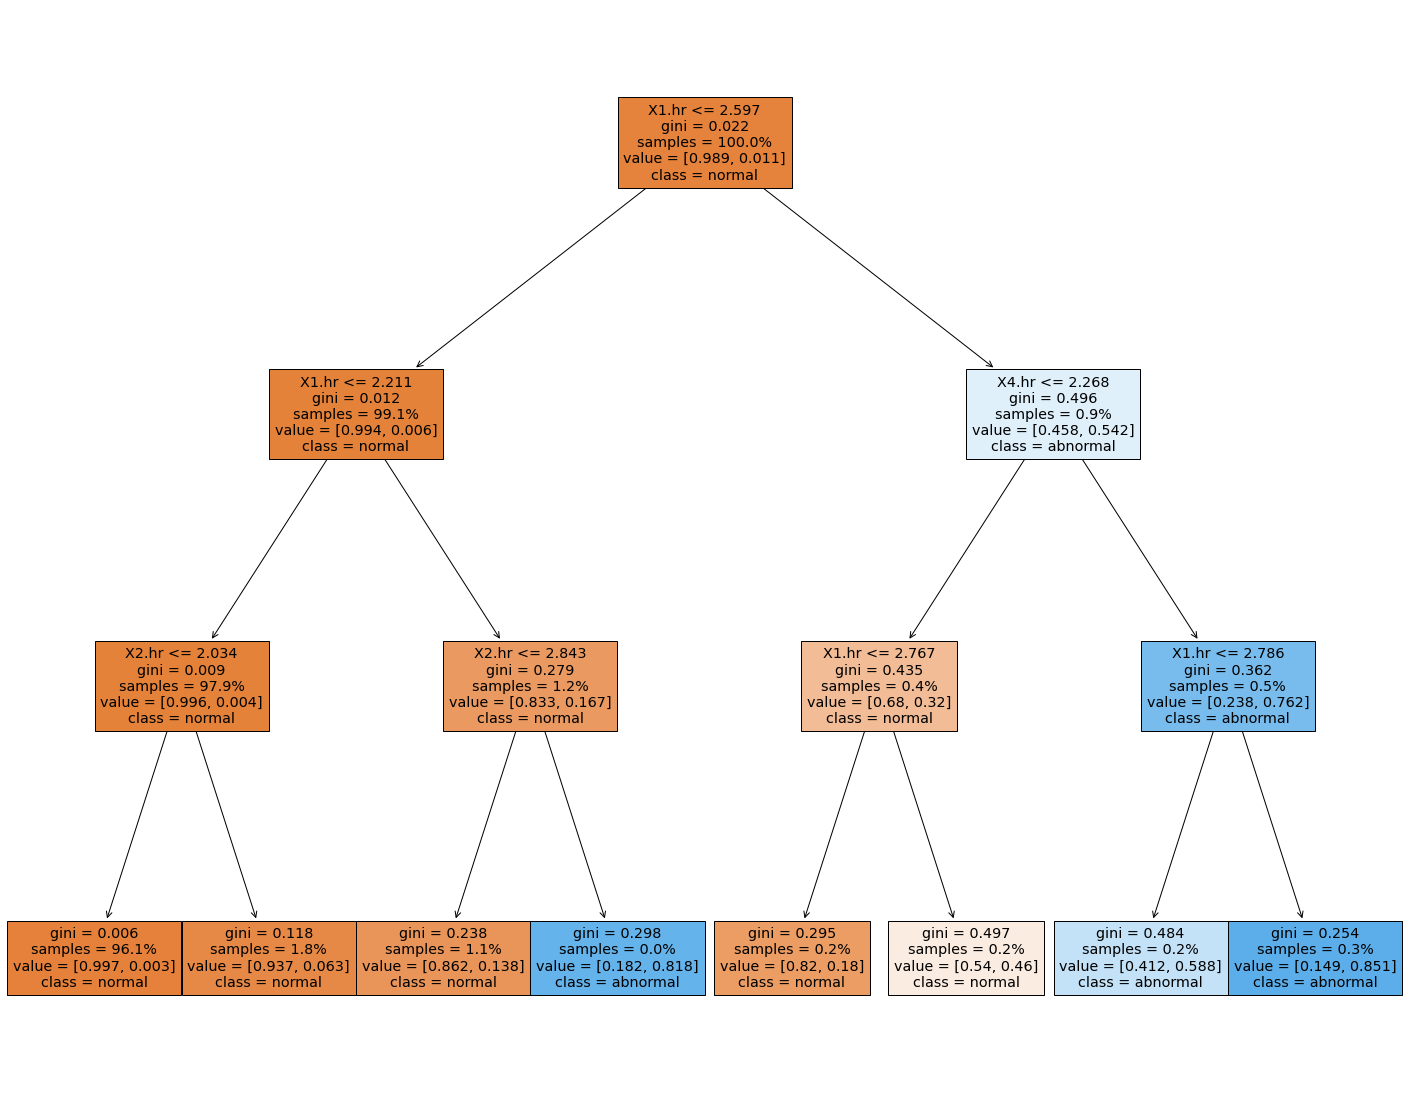

In [7]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 13)
clf.fit(X=X_train,y=y_train)

y_pred = clf.predict(X_test)

results = get_results(y_test, y_pred, results, 'Decision Tree')


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns,  
                   class_names=['normal', 'abnormal'],
                   filled=True,  proportion = True)


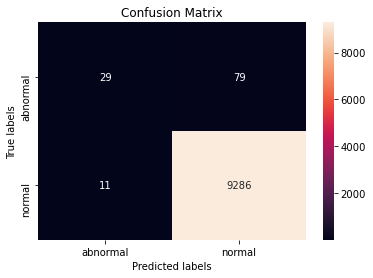

In [8]:
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['abnormal', 'normal']); 
ax.yaxis.set_ticklabels(['abnormal', 'normal'])

plt.show()

In [9]:
results

,accuracy,f1,precision,recall
Decision Tree,0.990431,0.391892,0.725,0.268519


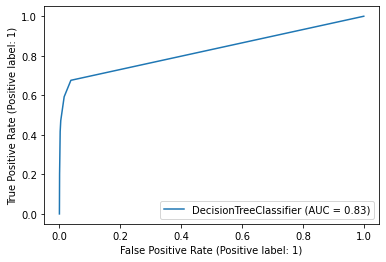

In [10]:
plot_roc_curve(clf,X_test,y_test)
plt.show()

In [11]:
y_score = clf.predict_proba(X_test)

In [12]:
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ["index"])
y_test = y_test.squeeze()

y_pred = pd.Series(y_pred)

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_score[indices, 1])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))


sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Bootstrap #1 ROC area: 0.846
Bootstrap #2 ROC area: 0.858
Bootstrap #3 ROC area: 0.811
Bootstrap #4 ROC area: 0.842
Bootstrap #5 ROC area: 0.799
Bootstrap #6 ROC area: 0.812
Bootstrap #7 ROC area: 0.802
Bootstrap #8 ROC area: 0.855
Bootstrap #9 ROC area: 0.824
Bootstrap #10 ROC area: 0.871
Bootstrap #11 ROC area: 0.840
Bootstrap #12 ROC area: 0.814
Bootstrap #13 ROC area: 0.862
Bootstrap #14 ROC area: 0.800
Bootstrap #15 ROC area: 0.817
Bootstrap #16 ROC area: 0.789
Bootstrap #17 ROC area: 0.834
Bootstrap #18 ROC area: 0.798
Bootstrap #19 ROC area: 0.859
Bootstrap #20 ROC area: 0.864
Bootstrap #21 ROC area: 0.836
Bootstrap #22 ROC area: 0.868
Bootstrap #23 ROC area: 0.873
Bootstrap #24 ROC area: 0.822
Bootstrap #25 ROC area: 0.815
Bootstrap #26 ROC area: 0.797
Bootstrap #27 ROC area: 0.812
Bootstrap #28 ROC area: 0.830
Bootstrap #29 ROC area: 0.843
Bootstrap #30 ROC area: 0.843
Bootstrap #31 ROC area: 0.805
Bootstrap #32 ROC area: 0.809
Bootstrap #33 ROC area: 0.835
Bootstrap #34 ROC a

Bootstrap #272 ROC area: 0.805
Bootstrap #273 ROC area: 0.811
Bootstrap #274 ROC area: 0.855
Bootstrap #275 ROC area: 0.854
Bootstrap #276 ROC area: 0.821
Bootstrap #277 ROC area: 0.810
Bootstrap #278 ROC area: 0.791
Bootstrap #279 ROC area: 0.890
Bootstrap #280 ROC area: 0.848
Bootstrap #281 ROC area: 0.822
Bootstrap #282 ROC area: 0.859
Bootstrap #283 ROC area: 0.869
Bootstrap #284 ROC area: 0.869
Bootstrap #285 ROC area: 0.807
Bootstrap #286 ROC area: 0.842
Bootstrap #287 ROC area: 0.832
Bootstrap #288 ROC area: 0.829
Bootstrap #289 ROC area: 0.855
Bootstrap #290 ROC area: 0.814
Bootstrap #291 ROC area: 0.815
Bootstrap #292 ROC area: 0.828
Bootstrap #293 ROC area: 0.832
Bootstrap #294 ROC area: 0.825
Bootstrap #295 ROC area: 0.845
Bootstrap #296 ROC area: 0.763
Bootstrap #297 ROC area: 0.830
Bootstrap #298 ROC area: 0.801
Bootstrap #299 ROC area: 0.833
Bootstrap #300 ROC area: 0.889
Bootstrap #301 ROC area: 0.846
Bootstrap #302 ROC area: 0.817
Bootstrap #303 ROC area: 0.828
Bootstra

Bootstrap #544 ROC area: 0.831
Bootstrap #545 ROC area: 0.825
Bootstrap #546 ROC area: 0.844
Bootstrap #547 ROC area: 0.854
Bootstrap #548 ROC area: 0.864
Bootstrap #549 ROC area: 0.840
Bootstrap #550 ROC area: 0.791
Bootstrap #551 ROC area: 0.808
Bootstrap #552 ROC area: 0.821
Bootstrap #553 ROC area: 0.876
Bootstrap #554 ROC area: 0.821
Bootstrap #555 ROC area: 0.811
Bootstrap #556 ROC area: 0.812
Bootstrap #557 ROC area: 0.822
Bootstrap #558 ROC area: 0.785
Bootstrap #559 ROC area: 0.811
Bootstrap #560 ROC area: 0.838
Bootstrap #561 ROC area: 0.868
Bootstrap #562 ROC area: 0.808
Bootstrap #563 ROC area: 0.822
Bootstrap #564 ROC area: 0.835
Bootstrap #565 ROC area: 0.831
Bootstrap #566 ROC area: 0.834
Bootstrap #567 ROC area: 0.814
Bootstrap #568 ROC area: 0.850
Bootstrap #569 ROC area: 0.818
Bootstrap #570 ROC area: 0.811
Bootstrap #571 ROC area: 0.826
Bootstrap #572 ROC area: 0.855
Bootstrap #573 ROC area: 0.812
Bootstrap #574 ROC area: 0.857
Bootstrap #575 ROC area: 0.818
Bootstra

Bootstrap #818 ROC area: 0.798
Bootstrap #819 ROC area: 0.851
Bootstrap #820 ROC area: 0.794
Bootstrap #821 ROC area: 0.812
Bootstrap #822 ROC area: 0.831
Bootstrap #823 ROC area: 0.803
Bootstrap #824 ROC area: 0.842
Bootstrap #825 ROC area: 0.847
Bootstrap #826 ROC area: 0.846
Bootstrap #827 ROC area: 0.814
Bootstrap #828 ROC area: 0.840
Bootstrap #829 ROC area: 0.771
Bootstrap #830 ROC area: 0.808
Bootstrap #831 ROC area: 0.814
Bootstrap #832 ROC area: 0.840
Bootstrap #833 ROC area: 0.788
Bootstrap #834 ROC area: 0.836
Bootstrap #835 ROC area: 0.826
Bootstrap #836 ROC area: 0.819
Bootstrap #837 ROC area: 0.830
Bootstrap #838 ROC area: 0.828
Bootstrap #839 ROC area: 0.779
Bootstrap #840 ROC area: 0.805
Bootstrap #841 ROC area: 0.819
Bootstrap #842 ROC area: 0.865
Bootstrap #843 ROC area: 0.810
Bootstrap #844 ROC area: 0.810
Bootstrap #845 ROC area: 0.816
Bootstrap #846 ROC area: 0.845
Bootstrap #847 ROC area: 0.868
Bootstrap #848 ROC area: 0.799
Bootstrap #849 ROC area: 0.811
Bootstra